In [1]:
import sys
sys.path.append("..")
import sound_eval as sev
import param_generation as pg
from common_vars import *
import imp
imp.reload(pg)
imp.reload(sev)
import imp
from deap import base, creator
import random
from deap import tools
import scipy.spatial.distance as d
from helpers import rToParams
from IPython.display import Audio
import pandas as pd
import seaborn as sns
dc = sev.drum_classifier()

In [45]:
toolbox = base.Toolbox()
POP_SIZE = 10
GREP,MUTPB = 0.5, 0.1
NGEN=30
STACK_SIZE=2
MUT_E=0.01
MUT_T=0.01

#prepare dataframe
df=pd.DataFrame(columns=["evo_round","pop_fitness","hof_fitness","hof_1","hof_2","hof_3"])

class drum_program():
    def __init__(self,stack_num=STACK_SIZE):
        self.program=[pg.RandomParams() for i in range(stack_num)]
    def mutate(self):
        for p in self.program:p.mutate(e=MUT_E,t=MUT_T,s=0.2)
        return self
creator.create("Fitness", base.Fitness, weights=(1,))
creator.create("Individual",drum_program, fitness=creator.Fitness)

drum="kick"

def initPopulation(pcls,ng):
    ipop=[creator.Individual()
          for x in range(ng)]
    return pcls(ipop)

def evaluate(individual,categorize=False):
    o=pg.ensemble(individual.program)
    dc.transformInput(o)
#     dvn=dc.getEnvDVN()
    if categorize:
        dc.getEnvFreqDVD()
    dvd=dc.getEnvFreqDVD()["kick"],

    return (dvd)

    
def randSelect(l,k):
    return random.sample(l, k)

# toolbox.register("individual_guess", initIndividual, creator.Individual)
toolbox.register("population_guess", initPopulation, list,)
toolbox.register("select_best", tools.selBest,fit_attr='fitness')
toolbox.register("select_random",randSelect)
toolbox.register("evaluate", evaluate)

hof=tools.HallOfFame(POP_SIZE)

In [46]:
%%time

#what's going on here?
# initiate new population, mutate them, evaluate
def evolve(pop,hof):
    newGenes=toolbox.population_guess(int(1*POP_SIZE))
    offspring = pop.copy()

    # Clone the selected individuals        
    for i,mutant in enumerate(offspring):
        if random.random()<MUTPB:
            offspring[i]=mutant.mutate()
            del offspring[i].fitness.values
    offspring = offspring + newGenes
    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    #update hof
    survivors = toolbox.select_best(offspring,POP_SIZE)
    return survivors.copy(),hof
    
def main(hof):
    pop = toolbox.population_guess(POP_SIZE)
    fitnesses = map(toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    for g in range(NGEN):
        pop,hof=evolve(pop,hof)
        hof.update(pop)
        hof_fitness=np.average([f.fitness.values[0] for f in hof])
        pop_fitness=np.average([f.fitness.values[0] for f in pop])
        print(g,NGEN,"\r",end="")
        df.loc[len(df)]=([g,pop_fitness,hof_fitness,hof[0].fitness.values,
                          hof[1].fitness.values,hof[2].fitness.values])
    return pop
pop=main(hof)


CPU times: user 4min 30s, sys: 1min 21s, total: 5min 52s
Wall time: 1min 17s


[(1.0,), (1.0,), (1.0,), (0.9999995231628418,), (0.9999772310256958,), (0.9764124155044556,), (0.962899923324585,), (0.01805724948644638,), (0.0022974489256739616,), (7.452885256498121e-06,)]


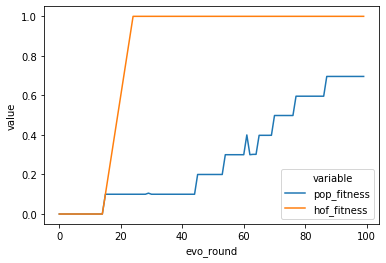

In [47]:
print([i.fitness.values for i in pop])
write_path="./experiment_data/%s-%s-%s-%s"%(NGEN,STACK_SIZE,MUT_E,MUT_T)
df.to_csv(write_path,index=False)
melted_df=pd.melt(df,id_vars=["evo_round"],value_vars=["pop_fitness","hof_fitness"])

ax=sns.lineplot(data=melted_df,x="evo_round",y="value",hue="variable")

# ax.set_yscale('log')

In [44]:
df

,evo_round,pop_fitness,hof_fitness,hof_1,hof_2,hof_3
0,0,2.026396e-29,2.026396e-29,"(1.1676656863395964e-28,)","(8.564769953763557e-29,)","(2.2534562896647587e-31,)"
1,1,1.828900e-23,1.828902e-23,"(1.8288977732370353e-22,)","(1.1676656863395964e-28,)","(1.1676656863395964e-28,)"
2,2,1.828900e-23,3.657802e-23,"(1.8288977732370353e-22,)","(1.8288977732370353e-22,)","(1.1676656863395964e-28,)"
3,3,1.828900e-23,5.486701e-23,"(1.8288977732370353e-22,)","(1.8288977732370353e-22,)","(1.8288977732370353e-22,)"
4,4,1.828900e-23,7.315598e-23,"(1.8288977732370353e-22,)","(1.8288977732370353e-22,)","(1.8288977732370353e-22,)"
5,5,1.828900e-23,9.144495e-23,"(1.8288977732370353e-22,)","(1.8288977732370353e-22,)","(1.8288977732370353e-22,)"
6,6,1.828906e-23,1.097340e-22,"(1.8288977732370353e-22,)","(1.8288977732370353e-22,)","(1.8288977732370353e-22,)"
7,7,1.828906e-23,1.280230e-22,"(1.8288977732370353e-22,)","(1.8288977732370353e-22,)","(1.8288977732370353e-22,)"
8,8,1.828903e-23,1.463119e-22,"(1.8288977732370353e-22,)","(1.8288977732370353e-22,)","(1.8288977732370353e-22,)"
9,9,1.828903e-23,1.646009e-22,"(1.8288977732370353e-22,)","(1.8288977732370353e-22,)","(1.8288977732370353e-22,)"


In [36]:
from ipywidgets import GridspecLayout,HBox,widgets
# What did our DAEP search return?

z=pop
x,y=3,int((len(z)/4))
grid=[]
grid = GridspecLayout(x, y)
for i in range(x):
    for j in range(y):
        o= widgets.Output()
        sample_number=i+j+(i*(y-1))
        pset=z[sample_number]
        try:
            out=pg.ensemble(pset.program)
            with o:
                display(Audio(out,rate=SR,autoplay=False,embed=True),pset.fitness.values,evaluate(pset,categorize=True),dc.envfreq_cat)
            grid[i, j] = o
        except:
            continue
display(grid)

(5.915322617511265e-05,)

(5.915322617511265e-05,)

'clap'

(0.7261849641799927,)

(0.7261849641799927,)

'synth_noise'

(0.9968706965446472,)

(0.9966668486595154,)

'synth_noise'

(0.9994903802871704,)

(0.9994903802871704,)

'synth_noise'

(0.9995360374450684,)

(0.9996071457862854,)

'synth_noise'

(0.9998481273651123,)

(0.9998738765716553,)

'synth_noise'

(0.999990701675415,)

(0.9999880790710449,)

'synth_noise'

(0.9999936819076538,)

(0.9999940395355225,)

'synth_noise'

(0.9999948740005493,)

(0.9999958276748657,)

'synth_noise'

(0.9999973773956299,)

(0.9999983310699463,)

'synth_noise'

(0.999997615814209,)

(0.9999974966049194,)

'synth_noise'

(0.9999977350234985,)

(0.9999977350234985,)

'synth_noise'

(0.9999979734420776,)

(0.9999961853027344,)

'synth_noise'

(0.9999991655349731,)

(0.9999996423721313,)

'synth_noise'

(0.9999996423721313,)

(0.9999995231628418,)

'synth_noise'

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [229]:
# z=toolbox.population_guess(2)[1]

# print(pg.ensemble(z.program))
# print(z)
# print(evaluate(z))
# for x in z.program:
#     print(x.__dict__)
#     for i in range(10):
#         x=x.mutate()
#     print(x.__dict__)

print(evaluate(z))
Audio(pg.ensemble(z),rate=SR,autoplay=True)

AttributeError: 'HallOfFame' object has no attribute 'program'